In [1]:
# from datetime import datetime
from IPython.display import display, Markdown
from datetime import datetime, date

todays_date = str(datetime.now().date())

display(Markdown(f'# Notebook - Antiberty embeddings generation VH_VL seqs - OVA & RBD'))
display(Markdown(f'Author: Lena Erlach'))
display(Markdown(f'Created: 2024-03-07'))
display(Markdown(f'Last modified: {todays_date}'))

# Notebook - Antiberty embeddings generation VH_VL seqs - OVA & RBD

Author: Lena Erlach

Created: 2024-03-07

Last modified: 2024-03-21

In [2]:
import os, sys, torch, tqdm, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from antiberty import AntiBERTyRunner
import configparser

sys.path.append('/data/cb/scratch/lenae/p-GP-LLM-AbPred/notebooks/')
import AbMAP_analysis.utils_abmap_analysis as utils_a
import utils_nb as utils

/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/cb/scratch/lenae/software/Anacon

### Custom functions

In [3]:
def generate_Antiberty_Seq_embedding(seq_HL, name, antiberty,
                                 out_folder = 'embeddings/', save_plm=True): 

    '''
    Function for generating Anitberty embeddings and saving them to a folder. Generates variable length embeddings of heavy and light chains in out_folder;

    params:
    seq_HL: list of 2 str, sequences of the heavy and light chains 
    name: str, seq_id of the sequence
    antiberty: loaded AntiBERTyRunner() object
    out_folder: str, path to the folder where the embeddings should be saved
    '''

    ids_to_drop = []

    if pd.isna(seq_HL[1]) is True: 
        VH_only = True 
    else:
        VH_only = False

    try:
        # embed the sequences
        if VH_only is True:
            embeddings_r = antiberty.embed(seq_HL[0])
            embeddings = [embeddings_r[0][1:-1,:].cpu().numpy(), np.nan]
        else:
            embeddings_r = antiberty.embed(seq_HL)
            embeddings = [embeddings_r[0][1:-1,:].cpu().numpy(), embeddings_r[1][1:-1,:].cpu().numpy()]

        # create folder for esm embeddings
        if save_plm == True:
            out_path_PLM = os.path.join(out_folder)
            if not os.path.isdir(out_path_PLM):
                os.mkdir(out_path_PLM)

            # save the embeddings
            for embedding, chain_type in zip([embeddings[0], embeddings[1]], ['H', 'L']):
                if chain_type == 'H':
                    file_name = '{}_{}.p'.format(name, chain_type)
                    #print(os.path.join(out_path_PLM, file_name))

                    with open(os.path.join(out_path_PLM, file_name), 'wb') as fh:
                        pickle.dump(embedding, fh)

                if chain_type == 'L' and VH_only is False:
                    file_name = '{}_{}.p'.format(name, chain_type)
                    with open(os.path.join(out_path_PLM, file_name), 'wb') as fh:
                        pickle.dump(embedding, fh)
    

    except:
        ids_to_drop.append(name)
        print('except')
    

    return embeddings, ids_to_drop


##### Functions for PCA  #####
def run_pca(fl_embeddings: np.array, n_comps: int = 2): 
    # Normalize the data
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(fl_embeddings)
    
    # Run PCA 
    pca = decomposition.PCA(n_components=n_comps)
    pca.fit(normalized_embeddings)
    PCs = pca.transform(normalized_embeddings)
    
    return PCs


##### Functions for PCA plots #####
def pca_plot(fl_embeddings: np.array, seq_df: pd.DataFrame, camsol_raw: pd.DataFrame = None, sample_ids: list = None, group_ids: list = None,
             n_comps: int = 2, n_comps_plot: tuple = (0,1), 
             model_name: str = "", plot_subtype = 'all'): 
    '''
    Custom PCA plots for Analysis of the OVA datasets
        param:
            fl_embeddings: np.array() of shape (n_samples, n_dim_embeddings) sequence based fixed-length embeddings
            n_comps: int, number of components to reduce the embeddings to with PCA.
            n_comps_plot: tuple, idxs of the PCs to plot on 2d scatter plot
            camsol_raw pd.dataframe: raw CamSol data loaded as pandas dataframe 
    
    
    '''
    
    # Run PCA 
    PCs = run_pca(fl_embeddings, n_comps = 2)
    
    # Setup of the Plots
    #if plot_subtype == 'all': dim = 2 else: dim = 1
        
    fig, axs = plt.subplots(2,2)
    fig.set_figwidth(14)
    fig.set_figheight(10)

    
    # Plot the with camsol
    if plot_subtype == 'camsol' or plot_subtype == 'all':
    
        # plot with CamSol
        points = axs[0,0].scatter(PCs[:,n_comps_plot[0]], PCs[:,n_comps_plot[1]], c=seq_df['protein variant score'], 
                                s=8, cmap="plasma")
        axs[0,0].set_title("PCA - {} Embeddings\nCamSol-intrinsic".format(model_name))
        fig.colorbar(points)


        axs[0,1].scatter(PCs[seq_df['protein variant score'] > 0][:,0], PCs[seq_df['protein variant score'] > 0][:,1], 
                       s=8, label='> 0')
        axs[0,1].scatter(PCs[seq_df['protein variant score'] <= 0][:,0], PCs[seq_df['protein variant score'] <= 0][:,1], 
                       s=8, label='<= 0')
        axs[0,1].legend(loc="upper right")

        plt.title("PCA - {} embeddings\nCamSol-intrinsic".format(model_name))
        
        
    # Plot the by group 
    if plot_subtype == 'groups' or plot_subtype == 'all':
            
        axs[1, 0].scatter(PCs[seq_df["group_id"] == group_ids[0]][:,n_comps_plot[0]], PCs[seq_df["group_id"] == group_ids[0]][:,n_comps_plot[1]], 
                          c='orange', s=15, alpha = 0.2, label='non-spec')
        axs[1, 0].scatter(PCs[seq_df["group_id"] == group_ids[1]][:,n_comps_plot[0]], PCs[seq_df["group_id"] == group_ids[1]][:,n_comps_plot[1]], 
                          c='purple', alpha = 0.5, s=15, label='spec')
        axs[1, 0].legend(loc="upper right")
        axs[1, 0].set_title("PCA - {} embeddings\ngroup_id".format(model_name))

        # plot samples_ids 
        samples_ids = np.unique(seq_df.sample_id)

        axs[1, 1].scatter(PCs[seq_df["sample_id"] == samples_ids[0]][:,n_comps_plot[0]], PCs[seq_df["sample_id"] == samples_ids[0]][:,n_comps_plot[1]], s=8, label='s2')
        axs[1, 1].scatter(PCs[seq_df["sample_id"] == samples_ids[1]][:,n_comps_plot[0]], PCs[seq_df["sample_id"] == samples_ids[1]][:,n_comps_plot[1]], s=8, label='s4')
        axs[1, 1].scatter(PCs[seq_df["sample_id"] == samples_ids[2]][:,n_comps_plot[0]], PCs[seq_df["sample_id"] == samples_ids[2]][:,n_comps_plot[1]], s=8, label='s1')
        axs[1, 1].scatter(PCs[seq_df["sample_id"] == samples_ids[3]][:,n_comps_plot[0]], PCs[seq_df["sample_id"] == samples_ids[3]][:,n_comps_plot[1]], s=8, label='s3')
        axs[1, 1].legend(loc="upper right")

        axs[1, 1].set_title("PCA - {} embeddings\nsample_id".format(model_name))
        
    fig.show()


### Data preparation - OVA

In [56]:
# setup parser for the config file
CONFIG_PATH = '/data/cb/scratch/lenae/p-GP-LLM-AbPred/notebooks/config_file.txt'
config = configparser.ConfigParser()
config.read(CONFIG_PATH)
ROOT_DIR = config['ROOT']['ROOT_DIR']

# Set input path Sequences 
seq_df_inputPath = os.path.join(ROOT_DIR, config['PATHS']['SEQ_DF'])


seq_col = "VDJ_VJ_aaSeq"    # column name of the sequence to filter for (VDJ_VJ_aaSeq, VDJ_aaSeq, ...)


# Set input path CamSol measure
camsol_inputPath = os.path.join(ROOT_DIR, 'data/raw/CamSol/CamSol_intrinsic2023-10-06_VDJ_VJ_aaSeq.txt')

# embedding paths for VH_VL embeddings
out_folder = os.path.join(ROOT_DIR, "data/processed/embeddings/Antiberty")


##### Setup the GPU support: 
cuda_dev_num = 4
if torch.cuda.is_available():
  dev = "cuda:{}".format(cuda_dev_num)
else:
  dev = "cpu"
device = torch.device(dev)
torch.cuda.set_device(device)

In [6]:
# load preprocessed dataframe
seq_df = pd.read_csv(seq_df_inputPath)
# filter df and drop 129 sequences which was also ignored in ESM embeddings
seq_df = seq_df[seq_df.seq_complete == True]
seq_df.drop(192, inplace=True)

seq_df = seq_df.reset_index(drop=True)

# get indeces/names and sequences as lists
names = seq_df.seq_id.tolist()
seqs_H = seq_df.VDJ_aaSeq.tolist()
seqs_L = seq_df.VJ_aaSeq.tolist() 
seqs_HL = [[seqs_H[i], seqs_L[i]] for i in range(len(seqs_H))]

# Load CamSol data
camsol_raw = pd.read_csv(camsol_inputPath, sep='\t')
camsol_raw.drop(columns=['intrinsic solubility profile'], inplace=True)

# add camsol column to seq_df based on the seq_id
camsol_raw.rename(columns={'Name': 'seq_id'}, inplace=True)
camsol_raw.drop(192, inplace=True)
seq_df = pd.merge(seq_df, camsol_raw, on=['seq_id'], how='left')


### Embed sequences with antiberty

In [81]:
emb_dict = {}
ids_to_drop = []
# load model
antiberty = AntiBERTyRunner()

# generate embeddings
for seq, name in tqdm.tqdm(zip(seqs_HL, names), total=len(seqs_HL)):
    # print(name)
    embeddings, ids_dropped = generate_Antiberty_Seq_embedding(seq_HL = seq, name= name, antiberty=antiberty,
                                    out_folder = out_folder, save_plm=True)
    emb_dict[name] = embeddings
    ids_to_drop.append(ids_dropped)   


# mean over embeddings
embeddings = [emb_dict[s] for s in names]
embeddings_m = utils_a.mean_over_HL(embeddings)                   

100%|██████████| 3807/3807 [01:15<00:00, 50.73it/s]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 512 and the array at index 1 has size 1

In [ ]:
### Create function to load embeddings
input_folder = out_folder 

#### Function to load emMbeddings
embeddings_loaded = utils.load_pickle_embeddings_VH_VL(names=names, inputPath=input_folder, embedding_type = 'var', file_suffix = '', verbose=False)
embeddings_m = utils_a.mean_over_HL(embeddings)


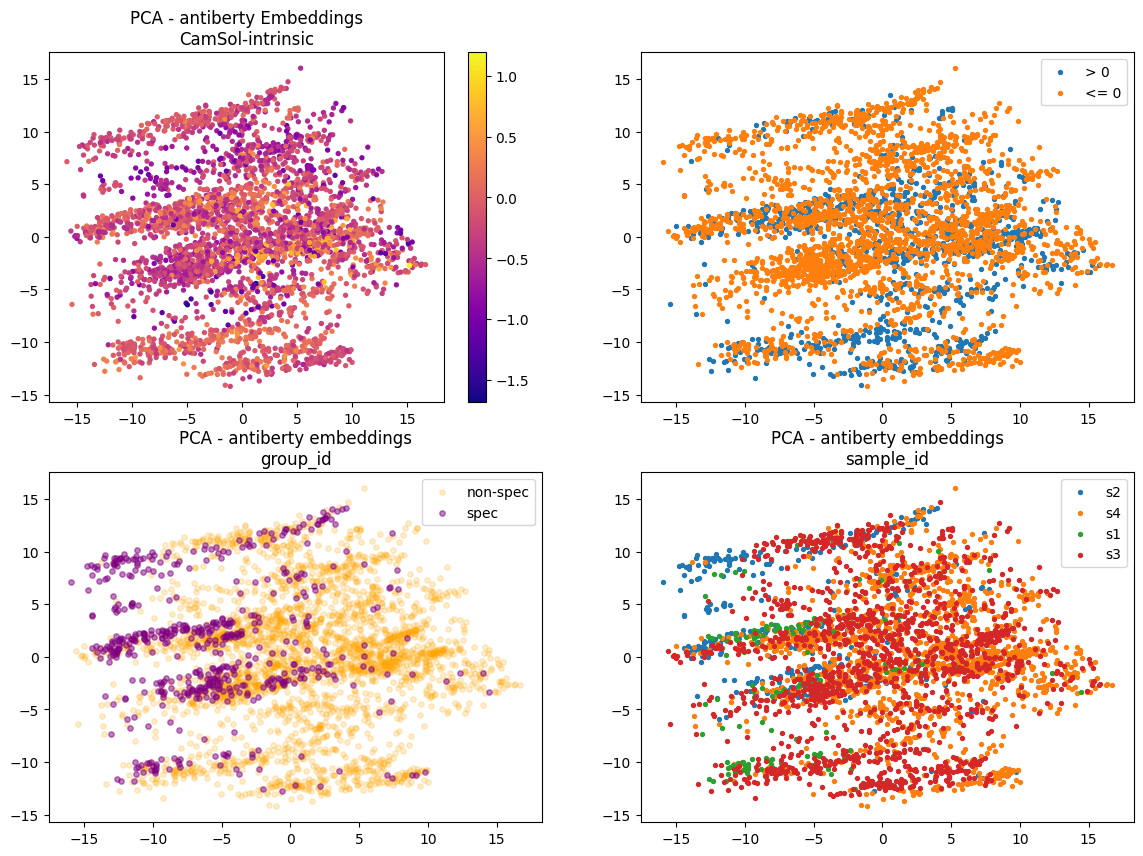

In [11]:
pca_plot(fl_embeddings= embeddings_m, seq_df = seq_df, sample_ids = ['s1','s2','s3','s4'], group_ids = [2,1],
             n_comps = 2, n_comps_plot= (0,1), 
             model_name = "antiberty", plot_subtype = 'all')

### Load VH embeddings

In [7]:
embeddings_raw = utils.load_pickle_embeddings(names, out_folder, file_suffix = '_H')
embeddings_m = np.array([emb.mean(0) for emb in embeddings_raw])
embeddings_m.shape

### Data preparation - RBD

In [10]:
# setup parser for the config file
CONFIG_PATH = '/data/cb/scratch/lenae/p-GP-LLM-AbPred/notebooks/config_file_RBD.txt'
config = configparser.ConfigParser()
config.read(CONFIG_PATH)
ROOT_DIR = config['ROOT']['ROOT_DIR']

# Set input path Sequences 
seq_df_inputPath = os.path.join(ROOT_DIR, config['PATHS']['SEQ_DF'])


seq_col = "VDJ_VJ_aaSeq"    # column name of the sequence to filter for (VDJ_VJ_aaSeq, VDJ_aaSeq, ...)


# # Set input path CamSol measure
# camsol_inputPath = os.path.join(ROOT_DIR, 'data/raw/CamSol/CamSol_intrinsic2023-10-06_VDJ_VJ_aaSeq.txt')

# embedding paths for VH_VL embeddings
out_folder = os.path.join(ROOT_DIR, "data/processed/embeddings/RBD/Antiberty")


##### Setup the GPU support: 
cuda_dev_num = 4
if torch.cuda.is_available():
  dev = "cuda:{}".format(cuda_dev_num)
else:
  dev = "cpu"
device = torch.device(dev)
torch.cuda.set_device(device)

In [8]:
# load preprocessed dataframe
seq_df = pd.read_csv(seq_df_inputPath)
# filter df 
seq_df = seq_df[seq_df.seq_complete == True]
seq_df = seq_df.reset_index(drop=True)

# get indeces/names and sequences as lists
names = seq_df.seq_id.tolist()
seqs_H = seq_df.VDJ_aaSeq.tolist()
seqs_L = seq_df.VJ_aaSeq.tolist() 
seqs_HL = [[seqs_H[i], seqs_L[i]] for i in range(len(seqs_H))]

# # Load CamSol data
# camsol_raw = pd.read_csv(camsol_inputPath, sep='\t')
# camsol_raw.drop(columns=['intrinsic solubility profile'], inplace=True)

# # add camsol column to seq_df based on the seq_id
# camsol_raw.rename(columns={'Name': 'seq_id'}, inplace=True)
# camsol_raw.drop(192, inplace=True)
# seq_df = pd.merge(seq_df, camsol_raw, on=['seq_id'], how='left')

In [12]:
emb_dict = {}
ids_to_drop = []
# load model
antiberty = AntiBERTyRunner()

# generate embeddings
for seq, name in tqdm.tqdm(zip(seqs_HL, names), total=len(seqs_HL)):
    # print(name)
    embeddings, ids_dropped = generate_Antiberty_Seq_embedding(seq_HL = seq, name= name, antiberty=antiberty,
                                    out_folder = out_folder, save_plm=True)
    emb_dict[name] = embeddings
    ids_to_drop.append(ids_dropped)   


# mean over embeddings
embeddings = [emb_dict[s] for s in names]
embeddings_m = utils_a.mean_over_HL(embeddings)  

100%|██████████| 3593/3593 [01:43<00:00, 34.77it/s]


IndexError: index 2 is out of bounds for axis 0 with size 2

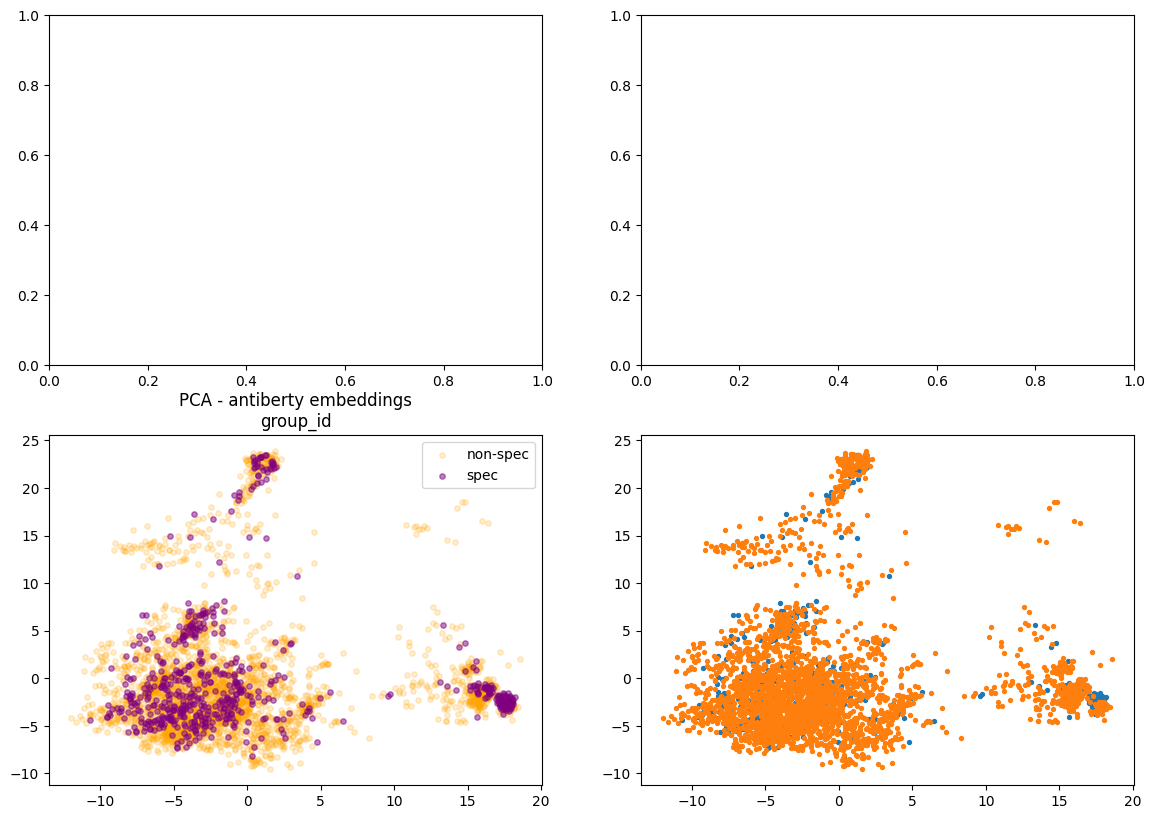

In [14]:
pca_plot(fl_embeddings= embeddings_m, seq_df = seq_df, sample_ids = ['s1','s2'], group_ids = [2,1],
             n_comps = 2, n_comps_plot= (0,1), 
             model_name = "antiberty", plot_subtype = 'groups')